In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

keras = tf.keras

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

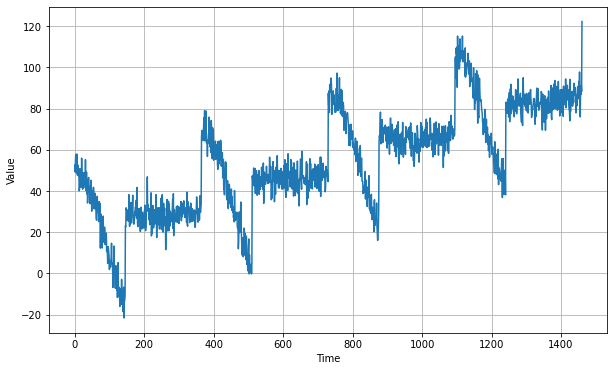

In [5]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

C:\Users\Mustafa Hasnain\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
33/33 [==============================] - 4s 16ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 1s 19ms/step - loss: 83.8978 - mae: 84.3978
Epoch 3/100
33/33 [==============================] - 1s 16ms/step - loss: 75.4974 - mae: 75.9974
Epoch 4/100
33/33 [==============================] - 1s 19ms/step - loss: 66.0676 - mae: 66.5676
Epoch 5/100
33/33 [==============================] - 1s 17ms/step - loss: 55.5131 - mae: 56.0131
Epoch 6/100
33/33 [==============================] - 0s 15ms/step - loss: 43.7599 - mae: 44.2597
Epoch 7/100
33/33 [==============================] - 1s 20ms/step - loss: 30.7909 - mae: 31.2900
Epoch 8/100
33/33 [==============================] - 1s 16ms/step - loss: 17.1478 - mae: 17.6436
Epoch 9/100
33/33 [==============================] - 1s 17ms/step - loss: 10.0311 - mae: 10.5178
Epoch 10/100
33/33 [==============================] - 1s 16ms/step - loss: 10.0607 - mae: 10.5524
Epoch 11/100
33/33 [=========

33/33 [==============================] - 1s 18ms/step - loss: 20.7832 - mae: 21.2787: 0s - loss: 18.3301 - mae: 18.82
Epoch 84/100
33/33 [==============================] - 1s 16ms/step - loss: 15.6071 - mae: 16.0986
Epoch 85/100
33/33 [==============================] - 1s 17ms/step - loss: 13.6352 - mae: 14.1254
Epoch 86/100
33/33 [==============================] - 1s 15ms/step - loss: 15.1949 - mae: 15.6857
Epoch 87/100
33/33 [==============================] - 1s 16ms/step - loss: 15.3841 - mae: 15.8769
Epoch 88/100
33/33 [==============================] - 1s 16ms/step - loss: 20.8376 - mae: 21.3332
Epoch 89/100
33/33 [==============================] - 1s 16ms/step - loss: 31.6068 - mae: 32.1027
Epoch 90/100
33/33 [==============================] - 1s 16ms/step - loss: 29.9876 - mae: 30.4870
Epoch 91/100
33/33 [==============================] - 1s 16ms/step - loss: 22.5008 - mae: 22.9941
Epoch 92/100
33/33 [==============================] - 1s 19ms/step - loss: 36.0259 - mae: 36.5213


(1e-08, 0.0001, 0.0, 30.0)

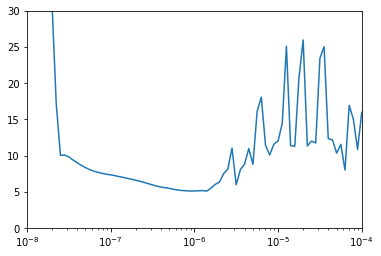

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 5s 49ms/step - loss: 30.0122 - mae: 30.5050 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/500
33/33 [==============================] - 1s 20ms/step - loss: 15.3618 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 1s 23ms/step - loss: 10.9284 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 1s 19ms/step - loss: 9.8165 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 1s 22ms/step - loss: 7.8424 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 1s 19ms/step - loss: 7.1708 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/500
33/33 [==============================] - 1s 21ms/step - loss: 5.9200 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/500
33/33 [==============================] - 1s 

33/33 [==============================] - 1s 19ms/step - loss: 4.8800 - mae: 5.3581 - val_loss: 7.7570 - val_mae: 8.2442
Epoch 63/500
33/33 [==============================] - 1s 21ms/step - loss: 4.8741 - mae: 5.3520 - val_loss: 7.7333 - val_mae: 8.2205
Epoch 64/500
33/33 [==============================] - 1s 26ms/step - loss: 4.8722 - mae: 5.3498 - val_loss: 7.6966 - val_mae: 8.1836
Epoch 65/500
33/33 [==============================] - 1s 20ms/step - loss: 4.8715 - mae: 5.3490 - val_loss: 7.6494 - val_mae: 8.1360
Epoch 66/500
33/33 [==============================] - 1s 18ms/step - loss: 4.8703 - mae: 5.3477 - val_loss: 7.5974 - val_mae: 8.0836
Epoch 67/500
33/33 [==============================] - 1s 20ms/step - loss: 4.8670 - mae: 5.3447 - val_loss: 7.5479 - val_mae: 8.0336
Epoch 68/500
33/33 [==============================] - 1s 23ms/step - loss: 4.8605 - mae: 5.3386 - val_loss: 7.5021 - val_mae: 7.9872
Epoch 69/500
33/33 [==============================] - 1s 20ms/step - loss: 4.8501 

33/33 [==============================] - 1s 21ms/step - loss: 4.5730 - mae: 5.0498 - val_loss: 6.3979 - val_mae: 6.8793
Epoch 124/500
33/33 [==============================] - 1s 21ms/step - loss: 4.5806 - mae: 5.0581 - val_loss: 6.3476 - val_mae: 6.8284
Epoch 125/500
33/33 [==============================] - 1s 21ms/step - loss: 4.5904 - mae: 5.0685 - val_loss: 6.2877 - val_mae: 6.7682
Epoch 126/500
33/33 [==============================] - 1s 19ms/step - loss: 4.5976 - mae: 5.0764 - val_loss: 6.2280 - val_mae: 6.7075
Epoch 127/500
33/33 [==============================] - 1s 19ms/step - loss: 4.6012 - mae: 5.0806 - val_loss: 6.1625 - val_mae: 6.6409
Epoch 128/500
33/33 [==============================] - 1s 19ms/step - loss: 4.6009 - mae: 5.0804 - val_loss: 6.1093 - val_mae: 6.5874
Epoch 129/500
33/33 [==============================] - 1s 19ms/step - loss: 4.5965 - mae: 5.0762 - val_loss: 6.0682 - val_mae: 6.5464
Epoch 130/500
33/33 [==============================] - 1s 19ms/step - loss: 

33/33 [==============================] - 1s 18ms/step - loss: 4.4777 - mae: 4.9560 - val_loss: 5.8716 - val_mae: 6.3484
Epoch 185/500
33/33 [==============================] - 1s 18ms/step - loss: 4.4720 - mae: 4.9500 - val_loss: 5.8624 - val_mae: 6.3390
Epoch 186/500
33/33 [==============================] - 1s 19ms/step - loss: 4.4672 - mae: 4.9447 - val_loss: 5.8582 - val_mae: 6.3347
Epoch 187/500
33/33 [==============================] - 1s 19ms/step - loss: 4.4631 - mae: 4.9402 - val_loss: 5.8564 - val_mae: 6.3328
Epoch 188/500
33/33 [==============================] - 1s 19ms/step - loss: 4.4601 - mae: 4.9368 - val_loss: 5.8563 - val_mae: 6.3327
Epoch 189/500
33/33 [==============================] - 1s 19ms/step - loss: 4.4579 - mae: 4.9344 - val_loss: 5.8564 - val_mae: 6.3327
Epoch 190/500
33/33 [==============================] - 1s 18ms/step - loss: 4.4564 - mae: 4.9328 - val_loss: 5.8560 - val_mae: 6.3324
Epoch 191/500
33/33 [==============================] - 1s 18ms/step - loss: 

33/33 [==============================] - 1s 18ms/step - loss: 4.4096 - mae: 4.8858 - val_loss: 5.9185 - val_mae: 6.3972
Epoch 246/500
33/33 [==============================] - 1s 18ms/step - loss: 4.3935 - mae: 4.8705 - val_loss: 5.5733 - val_mae: 6.0518
Epoch 247/500
33/33 [==============================] - 1s 18ms/step - loss: 4.4157 - mae: 4.8922 - val_loss: 5.7526 - val_mae: 6.2295
Epoch 248/500
33/33 [==============================] - 1s 18ms/step - loss: 4.4001 - mae: 4.8770 - val_loss: 5.6273 - val_mae: 6.1060
Epoch 249/500
33/33 [==============================] - 1s 18ms/step - loss: 4.4015 - mae: 4.8774 - val_loss: 5.8797 - val_mae: 6.3577
Epoch 250/500
33/33 [==============================] - 1s 18ms/step - loss: 4.3900 - mae: 4.8669 - val_loss: 5.5523 - val_mae: 6.0310
Epoch 251/500
33/33 [==============================] - 1s 18ms/step - loss: 4.4117 - mae: 4.8884 - val_loss: 5.7342 - val_mae: 6.2114
Epoch 252/500
33/33 [==============================] - 1s 18ms/step - loss: 

33/33 [==============================] - 1s 18ms/step - loss: 4.3796 - mae: 4.8561 - val_loss: 5.7502 - val_mae: 6.2300
Epoch 307/500
33/33 [==============================] - 1s 20ms/step - loss: 4.3626 - mae: 4.8395 - val_loss: 5.4120 - val_mae: 5.8932
Epoch 308/500
33/33 [==============================] - 1s 20ms/step - loss: 4.3900 - mae: 4.8682 - val_loss: 5.5981 - val_mae: 6.0768
Epoch 309/500
33/33 [==============================] - 1s 19ms/step - loss: 4.3792 - mae: 4.8555 - val_loss: 5.8681 - val_mae: 6.3469
Epoch 310/500
33/33 [==============================] - 1s 19ms/step - loss: 4.3652 - mae: 4.8428 - val_loss: 5.4380 - val_mae: 5.9191
Epoch 311/500
33/33 [==============================] - 1s 20ms/step - loss: 4.3833 - mae: 4.8613 - val_loss: 5.6333 - val_mae: 6.1124
Epoch 312/500
33/33 [==============================] - 1s 19ms/step - loss: 4.3667 - mae: 4.8425 - val_loss: 5.8503 - val_mae: 6.3295
Epoch 313/500
33/33 [==============================] - 1s 19ms/step - loss: 

33/33 [==============================] - 1s 18ms/step - loss: 4.3485 - mae: 4.8240 - val_loss: 5.8073 - val_mae: 6.2886
Epoch 368/500
33/33 [==============================] - 1s 18ms/step - loss: 4.3334 - mae: 4.8096 - val_loss: 5.3300 - val_mae: 5.8104
Epoch 369/500
33/33 [==============================] - 1s 18ms/step - loss: 4.3537 - mae: 4.8299 - val_loss: 5.5109 - val_mae: 5.9918
Epoch 370/500
33/33 [==============================] - 1s 18ms/step - loss: 4.3443 - mae: 4.8197 - val_loss: 5.8826 - val_mae: 6.3629
Epoch 371/500
33/33 [==============================] - 1s 18ms/step - loss: 4.3278 - mae: 4.8037 - val_loss: 5.3446 - val_mae: 5.8252
Epoch 372/500
33/33 [==============================] - 1s 18ms/step - loss: 4.3503 - mae: 4.8264 - val_loss: 5.5128 - val_mae: 5.9938
Epoch 373/500
33/33 [==============================] - 1s 18ms/step - loss: 4.3434 - mae: 4.8190 - val_loss: 5.8261 - val_mae: 6.3074
Epoch 374/500
33/33 [==============================] - 1s 18ms/step - loss: 

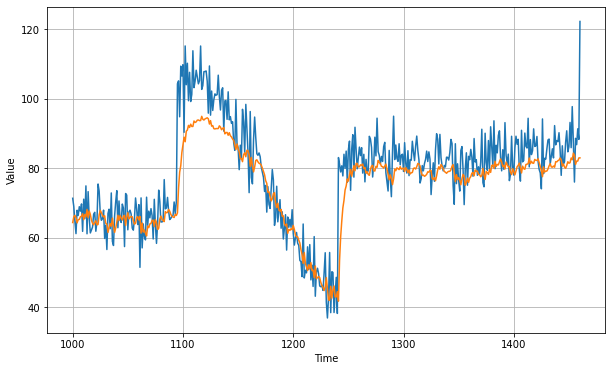

In [11]:
model = keras.models.load_model("my_checkpoint.h5")

rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.9196587